# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




### Objective:
- 1. Take top 2000 features from tf-idf vectorizers using idf_ score.
- 2. You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these

- 3. You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)
- 4. After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.
- 5. You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [48]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)



Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(87775, 10)


87.775

In [4]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [8]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [9]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [12]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [13]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [14]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [15]:
# Combining all the above stundents 
from tqdm import tqdm_notebook
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm_notebook(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [16]:
for i in range(5):
    print(preprocessed_reviews[i],'\n')

dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports 

dogs love saw pet store tag attached regarding made china satisfied safe 

infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money 

worst product gotten long time would rate no star could simply not catch single fly bug sort went hardware store bought old fashioned spiral fly paper effective unuasual influx flys house fall needed something 

wish would read reviews making purchase basically cardsotck box sticky outside pink ish things look like entrances trap pictures no inside 

In [17]:
final['CleanedText']=preprocessed_reviews

In [18]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [19]:
final_data = final['CleanedText'].values

In [20]:
final_data.shape

(87773,)

### Task 1: Take Top 2000 Features for TFIDF Vectorizer on CleanedText data

In [21]:
tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,1),max_features=2000)
tfidf_vec = tfidf.fit_transform(final_data)
print("Type of tfidf vectorizer",type(tfidf))
print("Shape if tfidf vectorizer is",tfidf_vec.get_shape())
print("Number of uniques words in vector is",tfidf_vec.get_shape()[1])



Type of tfidf vectorizer <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Shape if tfidf vectorizer is (87773, 2000)
Number of uniques words in vector is 2000


In [22]:
top_2000_words = tfidf.get_feature_names()

In [23]:
print(top_2000_words[:50])

['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'across', 'actual', 'actually', 'add', 'added', 'addicted', 'addictive', 'adding', 'addition', 'additional', 'additives', 'adds', 'admit', 'adult', 'adults', 'advertised', 'afford', 'affordable', 'afraid', 'afternoon', 'aftertaste', 'agave', 'age', 'ago', 'agree', 'ahead', 'air', 'allergic', 'allergies', 'allergy', 'allow', 'allows', 'almond', 'almonds', 'almost', 'alone', 'along', 'alot', 'already', 'also', 'alternative', 'although', 'always', 'amazed']


### Task 2: Create the Co-occurence matrix

In [24]:
# https://stackoverflow.com/questions/42814452/co-occurrence-matrix-from-list-of-words-in-python/42814963
# Find the co-occurence of matrix

####################################################
# final_data is cleaned data
# top_200_words -> top 2000 features
# n_neighbors is -> windows size
# co_occurence_matrix is 2D matrix
#####################################################

def find_Co_occurence_matrix(final_data,top_2000_words,n_neighbor,co_occurence_matrix):
    for row in tqdm_notebook(final_data):
        words_row = row.split()
        for index,word in enumerate(words_row):
            if word in top_2000_words:
                for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_row)-1) + 1):
                    if words_row[j] in top_2000_words:
                        co_occurence_matrix[top_2000_words.index(word),top_2000_words.index(words_row[j])] += 1
                    else:
                        pass
            else:
                pass
    return co_occurence_matrix

In [25]:
co_occurence_matrix = find_Co_occurence_matrix(final_data,top_2000_words,5,np.zeros((2000,2000)))


In [26]:
co_occurence_matrix[:5,:5]

array([[2.553e+03, 4.000e+00, 1.400e+01, 3.000e+00, 1.300e+01],
       [4.000e+00, 3.370e+02, 1.000e+00, 0.000e+00, 2.000e+00],
       [1.400e+01, 1.000e+00, 2.494e+03, 3.000e+00, 3.000e+00],
       [3.000e+00, 0.000e+00, 3.000e+00, 4.390e+02, 0.000e+00],
       [1.300e+01, 2.000e+00, 3.000e+00, 0.000e+00, 1.290e+03]])

In [27]:
type(co_occurence_matrix)

numpy.ndarray

### Task 3:  Apply the Truncated SVD and find maximum variance ratio

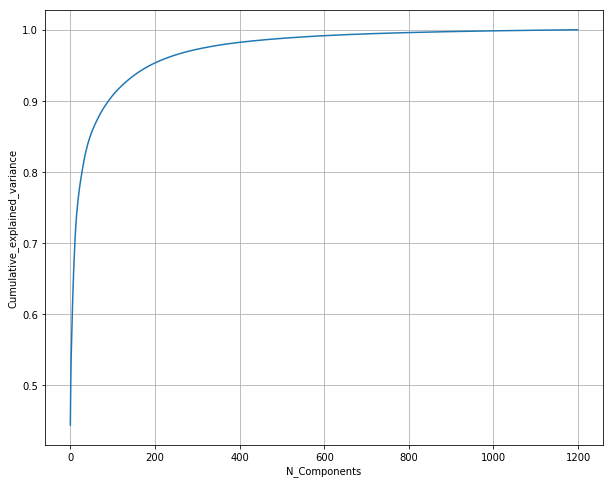

In [28]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1200) # here we choose random 1200 compoenets , further we will select best components
svd_dec= svd.fit_transform(co_occurence_matrix)
per_var_explained= svd.explained_variance_/np.sum(svd.explained_variance_)
cum_var_explained = np.cumsum(per_var_explained) # calculate cummulative sum variance ratio

# visulaize  the plot 
plt.figure(figsize=(10,8))
plt.plot(cum_var_explained)
plt.grid()
plt.xlabel('N_Components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

### Observation:
- We see that at N_Coomponents =200 we get more variance ratio more than 95%

### Task 4:  Apply the KMeans clusters on truncated svd data

In [29]:
from sklearn.cluster import KMeans
cluster_range = range(1,11)
cluster_errors = []

for i in tqdm_notebook(cluster_range):
    clusters = KMeans(n_clusters=i,n_init=5)
    clusters.fit(svd_dec)
    cluster_errors.append(clusters.inertia_ )

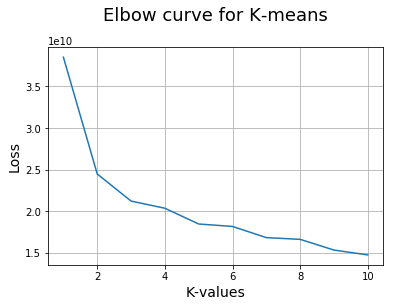

In [30]:
# plot the plot loos vs k values
plt.plot(cluster_range, cluster_errors)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Elbow curve for K-means\n',size=18)
plt.grid()
plt.show()

### Observation :
- We see that at K = 3 loss is sharply decreasing after that loss is increasing and decreasing. so we select best k values is 3

In [36]:
# apply the kmeans alogorithm

k_mean = KMeans(n_clusters=3, n_jobs=-1)
k_mean_pre = k_mean.fit_predict(svd_dec)

In [37]:
len(k_mean_pre)

2000

In [38]:
list_of_sent = []
for i in final_data:
    sent = []
    for word in i.split():
        sent.append(word)
    list_of_sent.append(sent)

In [114]:
index = []
index2 = []
index3 = []
for i in range(len(k_mean_pre)):
    if k_mean_pre[i] == 0:
        index.append(i)
    elif k_mean_pre[i] ==1:
        index2.append(i)
    else:
        index3.append(i)
        
        

        
print("Lenght of index1",len(index))
print("Lenght of index2",len(index2))
print("Lenght of index3",len(index3))



Lenght of index1 35
Lenght of index2 1
Lenght of index3 1964


In [135]:
index[:10]

[45, 51, 142, 143, 226, 316, 344, 409, 510, 548]

In [115]:
text1 = []
text2 = []
text3 = []

for i in range(len(index)):
    text1.append(list_of_sent[index1[i]])
    
for i in range(len(index2)):
    text2.append(list_of_sent[index2[i]])
    
for i in range(len(index3)):
    text3.append(list_of_sent[index3[i]])
    

In [116]:
from wordcloud import WordCloud #import wordcloud

def visulaize_wrodcloud(text):
    plt.figure(figsize=(15,10)) #figure size
    wordcloud = WordCloud(background_color="white",mode = "RGB", width = 1000, height=500).generate(text)
    plt.imshow(wordcloud,interpolation="bilinear") # show image

##### clsuter 1

In [117]:
text_data1 = ''
for i in range(len(text1)):
    for j in range(len(text1[i])):
        text_data1 = text_data1 + text1[i][j] + ' '


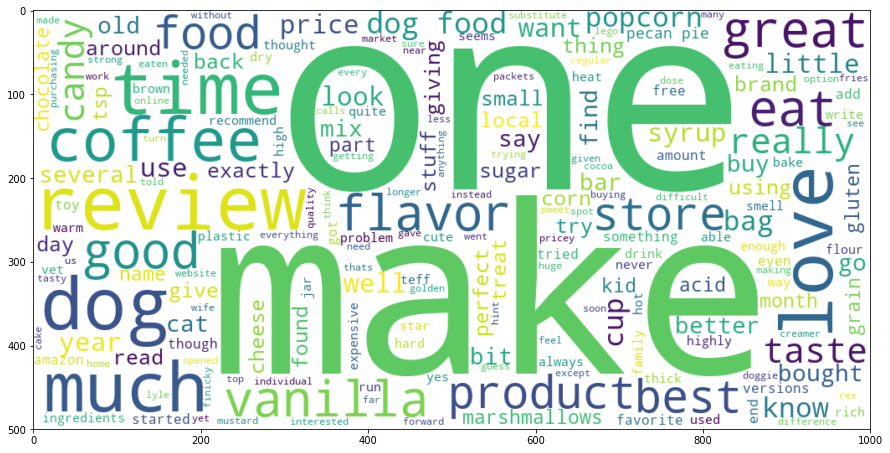

In [118]:
visulaize_wrodcloud(text_data1)

####  clsuter 2

In [119]:
text_data2 = ''
for i in range(len(text2)):
    for j in range(len(text2[i])):
        text_data2 = text_data2 + text2[i][j] + ' '


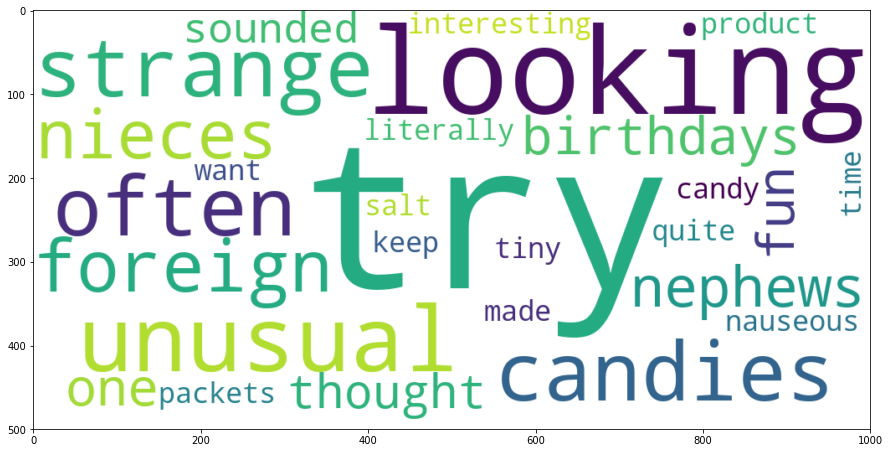

In [120]:
visulaize_wrodcloud(text_data2)

#### cluster 3

In [121]:
text_data3 = ''
for i in range(len(text3)):
    for j in range(len(text3[i])):
        text_data3 = text_data3 + text3[i][j] + ' '


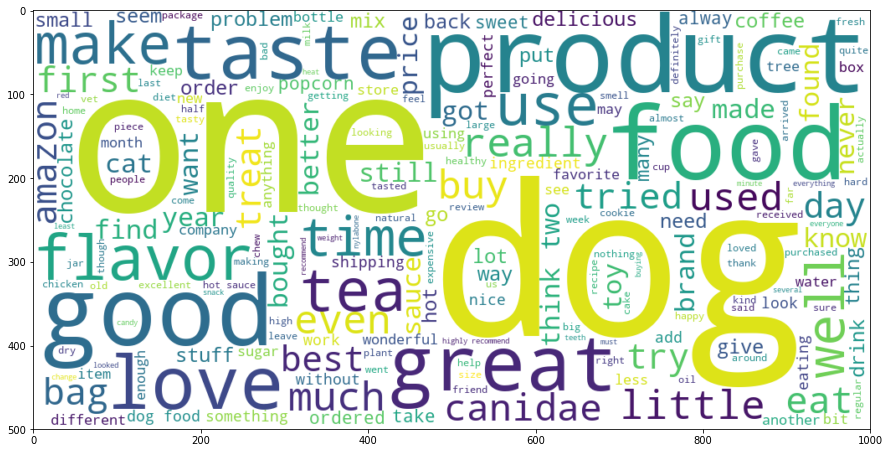

In [122]:
visulaize_wrodcloud(text_data3)

### Task 5: Find out the cosine similarty between words

In [136]:
def cosine_similarty_words(word):
    similarity = cosine_similarity(co_occurence_matrix)
    word_vect = similarity[top_2000_words.index(word)]
    print("Similar Words are to ->",word)
    index = word_vect.argsort()[::-1][1:6]
    for i in range(len(index)):
        print("Word",top_2000_words[index[i]] ,"is similar to",word,"\n")

In [137]:
top_2000_words[:10]

['able',
 'absolute',
 'absolutely',
 'according',
 'acid',
 'acidic',
 'across',
 'actual',
 'actually',
 'add']

In [138]:
cosine_similarty_words(top_2000_words[1])

Similar Words are to -> absolute
Word favorite is similar to absolute 

Word best is similar to absolute 

Word ever is similar to absolute 

Word far is similar to absolute 

Word not is similar to absolute 



In [139]:
similarty_words(top_2000_words[5])

Similar Words are to -> acidic
Word bitter is similar to acidic 

Word not is similar to acidic 

Word coffee is similar to acidic 

Word taste is similar to acidic 

Word strong is similar to acidic 



In [140]:
similarty_words(top_2000_words[20])

Similar Words are to -> adults
Word kids is similar to adults 

Word children is similar to adults 

Word not is similar to adults 

Word like is similar to adults 

Word great is similar to adults 



### Conclusion:

### Analysis of Truncated SVD 

- We did the text preprocessing for data
- Applied the TfidfVectorizer on the final data and selected top 2000 features. 
- We selected TruncatedSVD and choose random 1200 components. We find out the explained variance ratio and cummulative explained various ratio. Selecting the best components that cover maximum expalined variance ratio. Finally we selected n_components =200.
- We also plot K-values vs Loss 
-  We applied the KMeans clustering algorithm on truncated svd data and find out best cluster 
- Visualized wordcloud for each cluster
- We showed the cosine similarity between words
